In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Myscellaneous
import sys
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, mean_absolute_error as mae, root_mean_squared_error as rmse

# Lag Structure and Autocorrelation
from statsmodels.tsa.stattools import acf, pacf, ccf
from statsmodels.graphics.tsaplots import plot_acf

# Utilities
# Add project root to sys.path
ROOT = Path().resolve().parent  # notebook/ → project root
sys.path.append(str(ROOT / "src"))
import utils

In [3]:
# Settings
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

sns.set_theme(style="darkgrid")

## Data Loading

In [4]:
df = utils.load_psm_data(Path("../data/raw/measures_v2.csv"))
df.info()
display(df.describe().T.round(3))
utils.build_data_summary(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1330816 entries, 0 to 1330815
Data columns (total 14 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   profile_id      1330816 non-null  int64  
 1   time            1330816 non-null  float64
 2   u_q             1330816 non-null  float64
 3   coolant         1330816 non-null  float64
 4   stator_winding  1330816 non-null  float64
 5   u_d             1330816 non-null  float64
 6   stator_tooth    1330816 non-null  float64
 7   motor_speed     1330816 non-null  float64
 8   i_d             1330816 non-null  float64
 9   i_q             1330816 non-null  float64
 10  pm              1330816 non-null  float64
 11  stator_yoke     1330816 non-null  float64
 12  ambient         1330816 non-null  float64
 13  torque          1330816 non-null  float64
dtypes: float64(13), int64(1)
memory usage: 142.1 MB


,count,mean,std,min,25%,50%,75%,max
profile_id,1330816.0,34.066,20.643,1.000,16.000,32.000,54.000,69.000
time,1330816.0,6000.461,4483.044,0.000,2459.000,5104.500,8448.500,21985.000
u_q,1330816.0,54.279,44.173,-25.291,12.070,48.938,90.034,133.037
coolant,1330816.0,36.230,21.786,10.624,18.698,26.900,49.857,101.599
stator_winding,1330816.0,66.343,28.672,18.586,42.788,65.110,88.141,141.363
u_d,1330816.0,-25.134,63.092,-131.530,-78.691,-7.430,1.470,131.470
stator_tooth,1330816.0,56.879,22.952,18.134,38.416,56.036,75.587,111.946
motor_speed,1330816.0,2202.081,1859.663,-275.549,317.111,1999.977,3760.639,6000.015
i_d,1330816.0,-68.717,64.933,-278.004,-115.406,-51.094,-2.980,0.052
i_q,1330816.0,37.413,92.182,-293.427,1.096,15.774,100.612,301.708


{'Number of Rows': 1330816,
 'Number of Columns': 14,
 'Number of Profiles': 69,
 'Mean Duration (s)': np.float64(9643.09),
 'Sampling Frequency (Hz)': np.float64(2.0),
 'Memory Usage (MB)': np.float64(142.147),
 'Missing Data (%)': np.float64(0.0)}

The dataset contains 185 hours of sensor recordings from a Permanent Magnet Synchronous Motor (PMSM) at 2 Hz sampling frequency.  

| Name           | Role     | Unit | Category        | Description                                                                 |
|----------------|----------|------|----------------|-----------------------------------------------------------------------------|
| **u_q**        | Feature  | V    | Electrical (voltage) | q-axis stator voltage (dq-coordinates), set by control strategy.            |
| **u_d**        | Feature  | V    | Electrical (voltage) | d-axis stator voltage (dq-coordinates), set by control strategy.            |
| **i_q**        | Feature  | A    | Electrical (current) | q-axis stator current (torque-producing component).                         |
| **i_d**        | Feature  | A    | Electrical (current) | d-axis stator current (field/flux component, often near 0 or negative).     |
| **motor_speed**| Feature  | rpm  | Operating state | Resulting motor shaft speed. |
| **torque**     | Feature  | Nm   | Operating state | Resulting torque from strategy (positive = motoring, negative = regen).     |
| **coolant**    | Feature  | °C   | Boundary cond.  | Coolant temperature, affecting thermal rejection.                           |
| **ambient**    | Feature  | °C   | Boundary cond.  | Ambient air temperature around the motor/inverter.                          |
| **pm**            | Target | °C | Temperature     | Permanent magnet (Rotor) temperature          |
| **stator_winding** | Target | °C | Temperature     | Stator winding temperature                    |
| **stator_tooth**  | Target | °C | Temperature     | Stator tooth temperature                     |
| **stator_yoke**   | Target | °C | Temperature     | Stator yoke temperature                      |
| **profile_id**    | Context | –  | Contextual ID   | Identifier for measurement sessions / drive cycles.                         |

**Notes:**
- All signals are sampled at **2 Hz** (one row = 0.5 s).  
- `profile_id` distinguishes between different drive cycles (1–6 h each).  
- Voltage and current signals are given in the **d–q reference frame** (rotating synchronous frame).  
- Temperatures were measured with thermocouples (except **pm**, which used wireless thermography).  
- Motor speed is logged in **rpm** (must be converted to rad/s). 

## Data Quality Checks

### Constant / Low Variance Columns

Almost constant or low variance columns normally carry no predictive power and often mislead learning algorithms. Also they waste memory and computation power with no gain trade.

,profile_id,feature,mean,std,var,coef_var
0,1,u_q,5.894508,2.231838,4.981100,0.378630
1,1,coolant,18.542054,0.328558,0.107951,0.017720
2,1,stator_winding,51.110270,37.978699,1442.381611,0.743074
3,1,u_d,-2.815422,5.474471,29.969834,-1.944458
4,1,stator_tooth,39.106455,23.995088,575.764241,0.613584


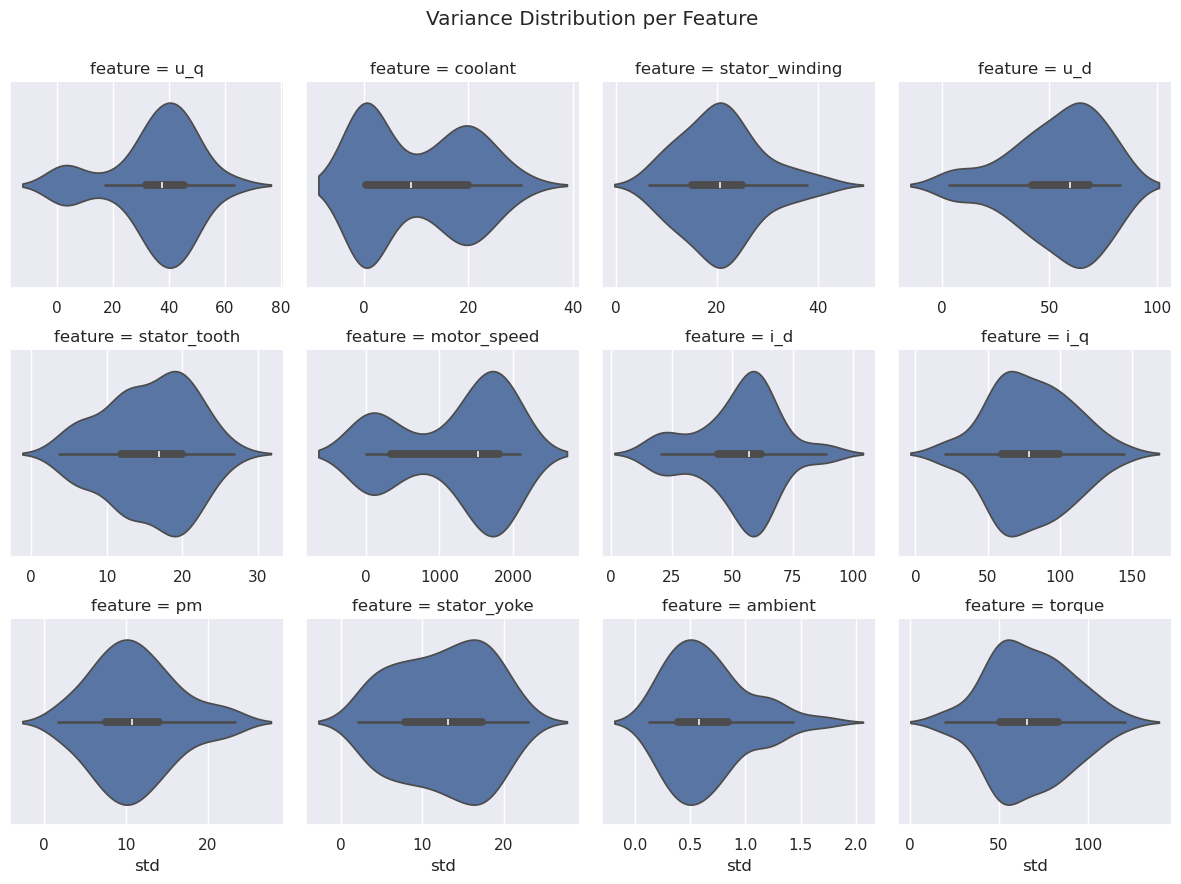

In [5]:
var_summary_df = utils.profile_variance_summary(df.drop(["time"], axis=1))
display(var_summary_df.head())

# Distribution of std per feature
g = sns.FacetGrid(var_summary_df, col="feature", col_wrap=4, sharex=False, sharey=False, height=3)
g.map(sns.violinplot, "std", orient="h")
g.figure.subplots_adjust(top=0.9)
g.figure.suptitle("Variance Distribution per Feature")
plt.show()

As observed, none of the features exhibit low variance across all profiles. Even if a feature is constant within a given profile ($var = 0$), it still carries valuable predictive information across the other profiles.

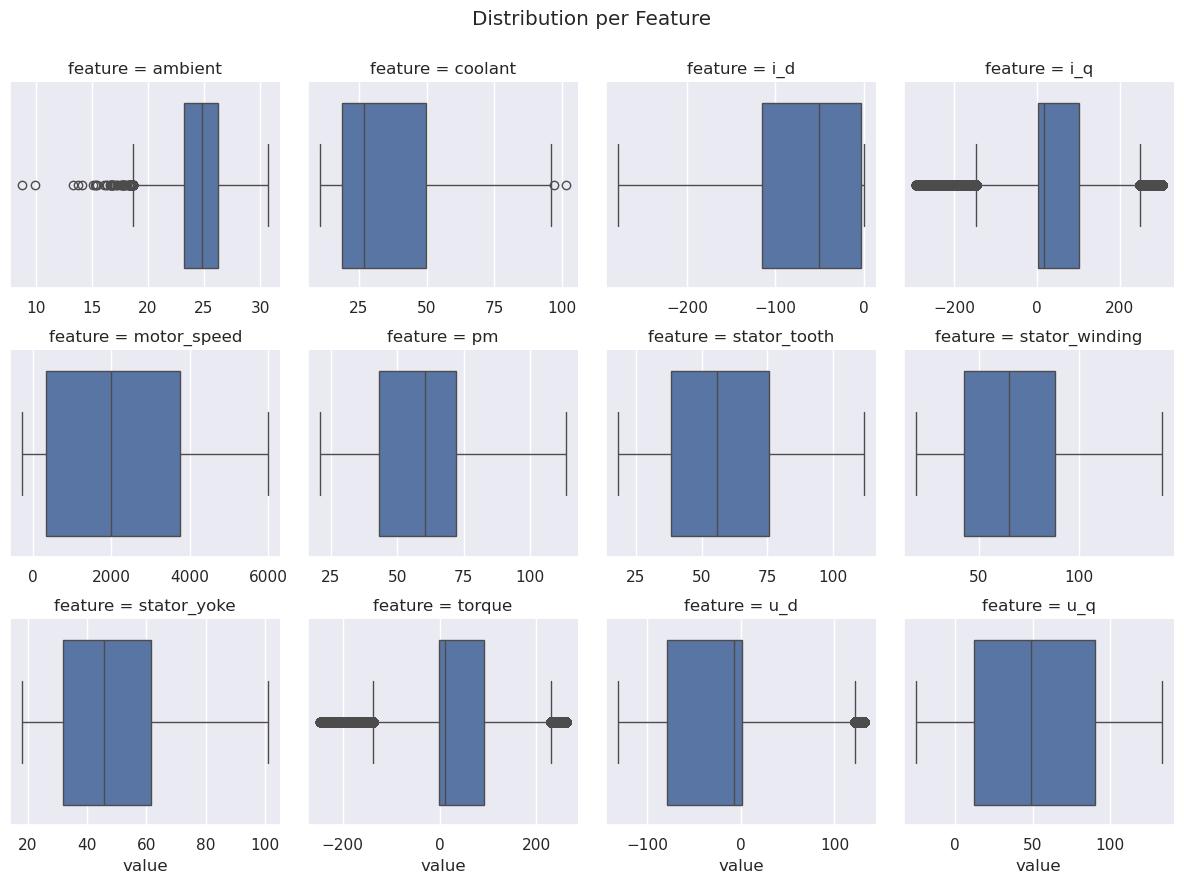

In [6]:
features = df.columns.difference(["time", "profile_id"])
df_long = df.copy().melt(id_vars=[], value_vars=features, var_name="feature")

# Distribution per feature
g = sns.FacetGrid(df_long, col="feature", col_wrap=4, sharex=False, sharey=False, height=3)
g.map(sns.boxplot, "value", orient="h")
g.figure.subplots_adjust(top=0.9)
g.figure.suptitle("Distribution per Feature")
plt.show()

The `stator_winding` temperature consistently reaches the highest values, making it a natural candidate for forecasting.  
However, the thermal behavior of PMSMs is highly dynamic: the location of the highest temperature can shift over time, which means that other stator components (yoke, tooth) should also be considered in the modeling.

In addition, we will also forecast the permanent magnet (`pm`, rotor) temperature. This serves two purposes:  
- It makes the challenge more interesting than simply modeling convection between stator and rotor.  
- The rotor temperature is not easily measurable in real-world applications, as the rotor is a moving component. A virtual sensor for `pm` therefore has clear practical value, offering a reliable and economical alternative to physical sensing.

In [7]:
DT = 0.5
TARGET = "stator_temperature"
df[TARGET] = df[["stator_winding", "stator_tooth", "stator_yoke"]].max(axis=1)

High temperatures in electric motors can lead to an increase in the stator winding resistance, which directly raises copper (ohmic) losses ($I^2R$). This not only reduces the overall efficiency of the machine but also accelerates insulation aging and increases the risk of thermal breakdown.

### Temporal Consistency Checks

Forecasting models are very sensitive to discontinuities, a single unrealistic spike can propagate through lagged features and bias training.

We concentrate the check in thermal variables, as for the others information specific to the machine and control strategies would be needed.

In [8]:
checks = {
    "stator_winding": {"abs": 5, "rel": 0.2},
    "stator_tooth":   {"abs": 5, "rel": 0.2},
    "stator_yoke":    {"abs": 5, "rel": 0.2},
    "pm":             {"abs": 5, "rel": 0.2},
    "ambient":        {"abs": 5, "rel": 0.2},
    # "torque":         {"abs": 100, "rel": 2.0, "require_pers": True, "pers_len": 4}
}

all_masks_df = utils.check_derivatives(
    df,
    checks,
    time_var="time",
    group_var="profile_id"
)

In [9]:
persist_cols = [c for c in all_masks_df.columns if c.endswith('_mask_persist')]
mask_cols = persist_cols if persist_cols else [c for c in all_masks_df.columns if c.endswith('_mask_any')]

# profile with most total True across mask columns
counts = (all_masks_df.groupby('profile_id')[mask_cols].sum())
counts['total_flags'] = counts.sum(axis=1)
worse_prof = counts['total_flags'].idxmax()

# slice both DFs for that profile, aligned by time
mask_slice = (all_masks_df[all_masks_df['profile_id'] == worse_prof].sort_values('time').reset_index(drop=True))
data_slice = (df[df['profile_id'] == worse_prof].sort_values('time').reset_index(drop=True))

# plot anomalies per feature
for mcol in mask_cols:
    col = mcol.replace('_mask_persist', '').replace('_mask_any', '')
    if col not in data_slice.columns:
        continue
    mask = mask_slice[mcol].astype(bool)
    if mask.sum() == 0:
        continue

    anomalies = data_slice.loc[mask, ['time', col]]
    print(f"Feature: {col}, Anomalies in profile {worse_prof}: {len(anomalies)} points")

    fig = px.line(data_slice, x='time', y=col,
                  title=f"Temporal consistency anomalies: {col} (Profile {worse_prof})")
    fig.add_scatter(x=anomalies['time'], y=anomalies[col],
                    mode='markers',
                    marker=dict(color='red', size=6),
                    name='Anomaly')
    fig.show()

Feature: ambient, Anomalies in profile 33: 7 points


### Physics Consistency

#### Electrical $\leftrightarrow$ Mechanical Power Balance

The overall power balance for a three-phase motor can be written as:

$$
P_e = P_m + P_\text{losses} 
\quad \text{or equivalently} \quad 
P_e = P_m \cdot \eta
$$

Since we do not have access to the motor efficiency $\eta$, we will use the first form of the equation, decomposed as follows:

1. **Electrical input power (dq-frame)**: Under the hypothesis of a balanced three-phase system, the zero-sequence components of voltage and current ($V_0, I_0$) are zero.  
This leaves us with the instantaneous electrical power in the dq-coordinates: $$ P_e = \tfrac{3}{2}(v_d i_d + v_q i_q) $$

1. **Mechanical output power**: Mechanical power is given by torque and angular speed: $$ P_m = T \cdot \omega $$ where $T$ is the torque [Nm] and $\omega$ is the angular speed [rad/s].

2. **Losses**: Losses in an electric motor include ohmic (copper), mechanical, stray, and iron losses. In our dataset we only have enough information to approximate part of the ohmic (copper) losses, related to the stator winding resistance $R_s$: $$ P_\text{Ohm} = R_s \,(i_d^2 + i_q^2) $$
Since $R_s$ is unknown, we use the squared current terms as a proxy to capture at least the relative trend of copper losses.

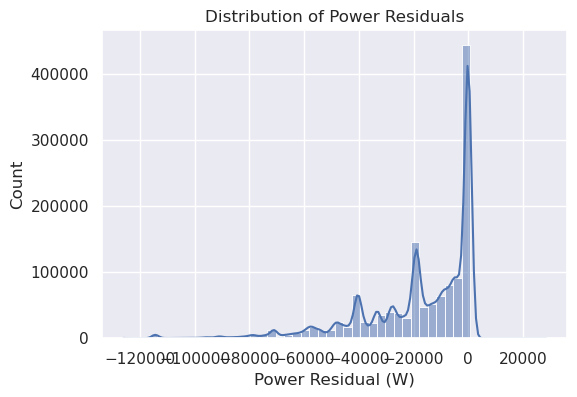

In [10]:
# Electrical power
df["p_e"] = (3/2)*(df["u_d"]*df["i_d"] + df["u_q"]*df["i_q"])

# Mechanical power
df["omega_rad_s"] = df["motor_speed"] * (2*np.pi/60.0)
df["p_mech"] = df["torque"] * df["omega_rad_s"]

# Copper loss proxy
df["p_cu"] = df["i_d"]**2 + df["i_q"]**2

# P mechanical + P copper loss
df["p_mech_plus_p_cu"] = df["p_mech"] + df["p_cu"]

# Power residual
df["p_res"] = df["p_e"] - df["p_mech_plus_p_cu"]

fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(df["p_res"], bins=50, kde=True)
ax.set_title("Distribution of Power Residuals")
ax.set_xlabel("Power Residual (W)")
plt.show()

Since $Rs$ is unknown, the power residuals are systematically biased (acting like a missing scaling factor). This makes it difficult to set a physics-based threshold for flagging outliers.

As an alternative, we can assess data quality and signal health by examining correlations, both linear (Pearson) and monotonic (Spearman), to verify whether the variables exhibit the expected physical relationships.

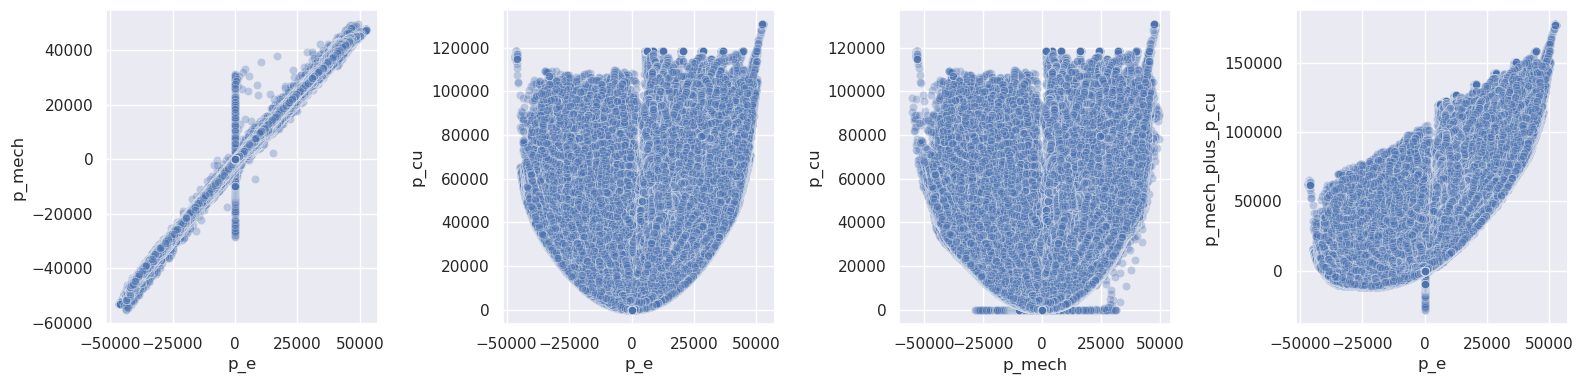

In [11]:
pairs = [
    ("p_e vs p_mech",        "p_e",    "p_mech"),
    ("p_e vs p_cu",          "p_e",    "p_cu"),
    ("p_mech vs p_cu",       "p_mech", "p_cu"),
    ("p_e vs (p_mech+p_cu)", "p_e",    "p_mech_plus_p_cu"),
]

fig, axes = plt.subplots(1, len(pairs), figsize=(16, 4))
axes = axes.flatten()

for ax, (_, x, y) in zip(axes, pairs):
    sns.scatterplot(x=x, y=y, data=df, alpha=0.3, ax=ax)
    ax.set_xlabel(x)
    ax.set_ylabel(y)

plt.tight_layout()
plt.show()

In [12]:
rows = []
for label, a, b in pairs:
    # Drop rows with NaNs in either column to keep comparisons fair
    sub = df[[a, b]].dropna()
    pearson  = sub.corr(method="pearson").iloc[0,1]
    spearman = sub.corr(method="spearman").iloc[0,1]
    rows.append({"features": label, "Pearson": pearson, "Spearman": spearman})

corr_df = pd.DataFrame(rows).set_index("features").round(6)
display(corr_df)

,Pearson,Spearman
features,,
p_e vs p_mech,0.997840,0.962026
p_e vs p_cu,0.389855,0.501855
p_mech vs p_cu,0.339524,0.456621
p_e vs (p_mech+p_cu),0.818438,0.872128


1. $P_e$ vs $P_m$: Very strong linear (Pearson ~0.998) and monotonic (Spearman ~0.96) relationship → confirms dataset consistency and correct physics between input and output power.
2. $P_e$ vs $P_{cu}$: Weak linear (Pearson ~0.39) but moderate monotonic (Spearman ~0.50) correlation → losses scale nonlinearly with input power but still follow its trend, making them relevant for thermal dynamics.  
3. $P_m$ vs $P_{cu}$: Weak linear (Pearson ~0.34) and moderate monotonic (Spearman ~0.46) → expected since torque–speed product and current-squared terms capture different aspects of motor behavior.  
4. $P_e$ vs $(P_m + P_{cu})$: Strong correlations (Pearson ~0.82, Spearman ~0.87) → combined proxy explains most of the electrical input, though non-linearities and unmodeled losses (iron, stray, mechanical) remain.  

## Profile Analysis

A driving-profile-wise analysis will allows to understand and identify sistematic differences in motor temperature dynamics, thermically demanding profiles and identify is whether we need profile-aware splits for training/testing.

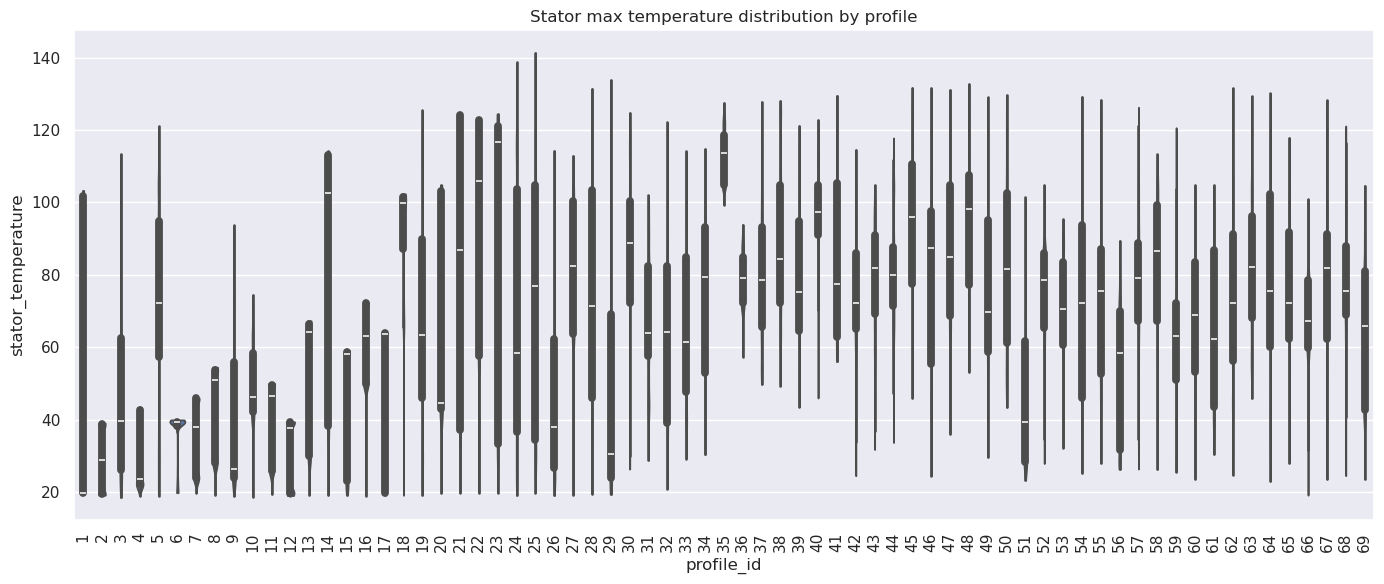

In [13]:
plt.figure(figsize=(14,6))
sns.violinplot(data=df, x="profile_id", y=TARGET, inner="box", cut=0)
plt.xticks(rotation=90)
plt.title("Stator max temperature distribution by profile")
plt.tight_layout()
plt.show()

Just by analyzing the `stator_temperature` distribution across profile, it can be seen an aopportunity for clustering profiles into different categories that would support a more informed training of the models:

- Low-temperature clusters: Some profiles never push the stator much beyond 40–60 °C. Likely mild duty cycles or low loads.

- High-temperature clusters: Other profiles sustain much higher medians (80–110 °C), with peaks above 120 °C. These represent harsher regimes.

- High variability profiles: Some profiles show very wide distributions, indicating aggressive cycles with fast ramps or stop-and-go behaviour.

- Narrow distributions: A few profiles stay within a tight band, suggesting controlled or constant-load cycles.

In [14]:
profile_features_df = utils.extract_profile_features(df, group_var="profile_id", time_var="time")

# Scale features
X = profile_features_df
X_scaled = StandardScaler().fit_transform(X.fillna(0))

# PCA for dimensionality reduction (avoid curse of dimensionality)
pca = PCA(n_components=15, random_state=RANDOM_SEED)
X_pca = pca.fit_transform(X_scaled)

profile_features_df["pca1"] = X_pca[:,0]
profile_features_df["pca2"] = X_pca[:,1]

print("Explained variance ratio:", pca.explained_variance_ratio_.sum())

# K clusters choice via Elbow and Silhouette methods
ks = range(2, 11)
inertias, sils = [], []

for k in ks:
    km = KMeans(n_clusters=k, n_init="auto", random_state=RANDOM_SEED)
    labels = km.fit_predict(X_pca)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(X_pca, labels))

elbow = pd.DataFrame({"k": ks, "inertia": inertias, "silhouette": sils})
display(elbow)

Explained variance ratio: 0.9131728463915443


,k,inertia,silhouette
0,2,9184.693362,0.301095
1,3,7131.161434,0.316418
2,4,6088.756995,0.337775
3,5,5677.220872,0.202362
4,6,4870.829748,0.216513
5,7,4619.076184,0.203149
6,8,4224.469481,0.215982
7,9,3915.829681,0.218223
8,10,3612.252771,0.244100


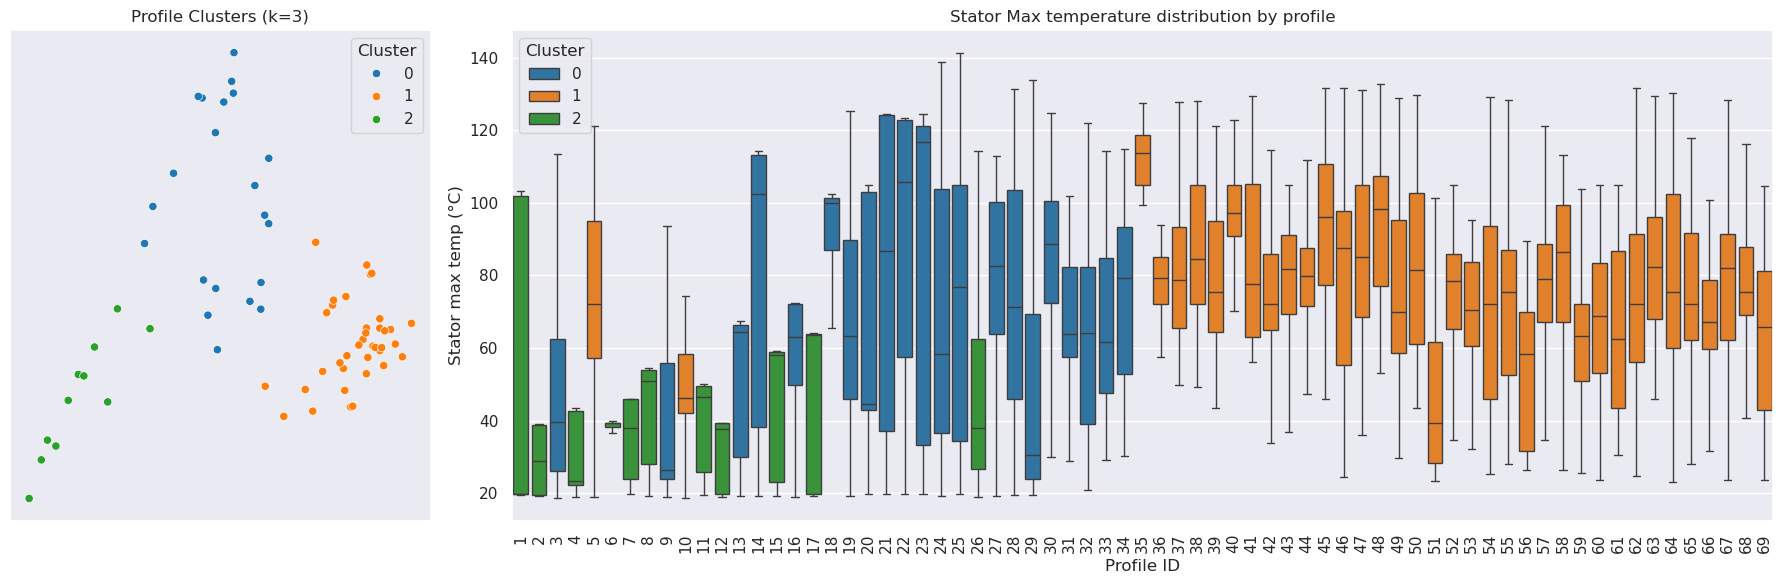

In [15]:
best_k = 3
km = KMeans(n_clusters=best_k, n_init="auto", random_state=RANDOM_SEED)
profile_features_df["cluster"] = km.fit_predict(X_pca)

# Map cluster labels back to the main df
df["cluster"] = df["profile_id"].map(profile_features_df["cluster"])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6),  gridspec_kw={'width_ratios': [1, 3]})
# PCA scatter
sns.scatterplot(data=profile_features_df, x="pca1", y="pca2", hue="cluster", palette="tab10", ax=ax1)
ax1.set_title(f"Profile Clusters (k={best_k})")
ax1.legend(title="Cluster", loc="best")
ax1.grid(True)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xlabel("")
ax1.set_ylabel("")

# Boxplot by profile_id with cluster hue
sns.boxplot(data=df, x="profile_id", y=TARGET, hue="cluster", palette="tab10", showfliers=False, ax=ax2)
ax2.set_title("Stator Max temperature distribution by profile")
ax2.set_xlabel("Profile ID")
ax2.set_ylabel("Stator max temp (°C)")
ax2.tick_params(axis="x", rotation=90)
ax2.legend(title="Cluster")

plt.tight_layout()
plt.show()

## Autocorrelation and Lag Structure

Forecasting models use windows of past observations, often referred to as **lags**, as inputs. To understand how past values of the system relate to its future behavior, and to determine how far ahead we can reliably forecast, we first need to analyze the system’s **lag structure** and **autocorrelation**.

### Autocorrelation Function

Even though this forecasting problem does not use the target signal as an input, analyzing its autocorrelation is still valuable. It provides insight into how much of the thermal behavior is explained by the target’s own past values, and gives a baseline idea of the “memory” or temporal dependence that the input features must attempt to replicate.

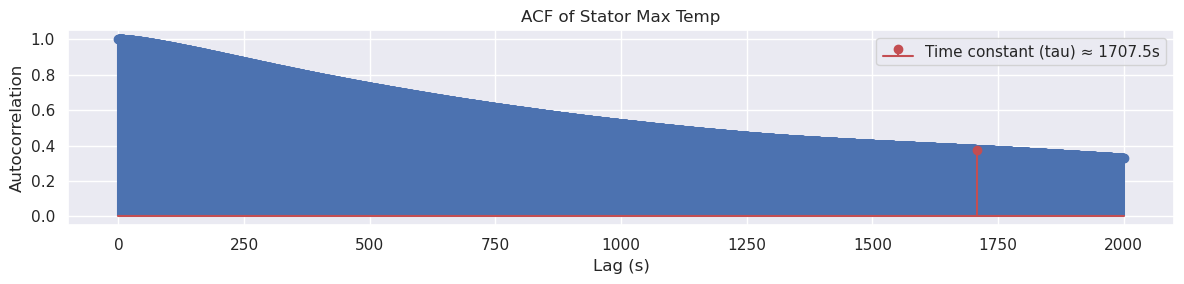

In [16]:
N_LAGS = 4000
y = df[TARGET].dropna()
y_std = (y - y.mean()) / (y.std() + 1e-9)

acf_vals = acf(y_std, nlags=N_LAGS, fft=True)

tau_val = 1 - (1 * 0.623)
tau = np.argmin(np.abs(acf_vals - tau_val)) * DT # in seconds

plt.figure(figsize=(12,3))
plt.stem(np.arange(len(acf_vals))*DT, acf_vals)
plt.stem(tau, acf_vals[int(tau/DT)], linefmt='r-', markerfmt='ro', basefmt='r-', label=f'Time constant (tau) ≈ {tau:.1f}s')
plt.title("ACF of Stator Max Temp")
plt.xlabel("Lag (s)")
plt.ylabel("Autocorrelation")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

The `stator_winding` temperature shows an extremely slow ACF decay, reflecting long-term thermal memory. If we approximate the ACF behavior as a first order system, then its time constant $\tau$ is the instant $t$ where its value reaches $63.2\%$ of its final value $\approx 0.377$.

$$ \tau_{ACF} \approx 1707.5 s $$

This time constant tells us **how long** `stator winding` **past values remain informative under the driving cycles**.

### Partial Autocorrelation Function

PACF removes the effects of intermediate lags, showing only the direct contribution of each lag.

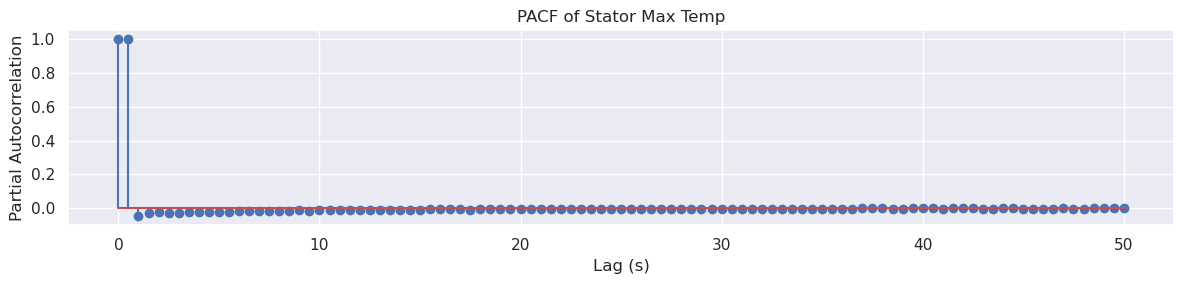

In [17]:
pacf_vals = pacf(y_std, nlags=100, method="ywm")

plt.figure(figsize=(12,3))
plt.stem(np.arange(len(pacf_vals))*DT, pacf_vals)
plt.title("PACF of Stator Max Temp")
plt.xlabel("Lag (s)")
plt.ylabel("Partial Autocorrelation")
plt.tight_layout()

The PACF indicates that only the nearest lags (1–2 steps) carry direct autoregressive information for the current temperature. When compared with the ACF, this suggests that the long tail of correlations in the ACF plot is not due to direct lag effects but rather to the cumulative persistence of thermal inertia.

For modeling, this creates a trade-off:

- Using only 1–2 lags would neglect the long-term dependencies that are critical in thermal dynamics.
- On the other hand, using very long raw sequences to capture all of the ACF’s persistence would increase computational cost and raise training difficulties (e.g., vanishing gradients in RNNs).

### Cross Correlation Function

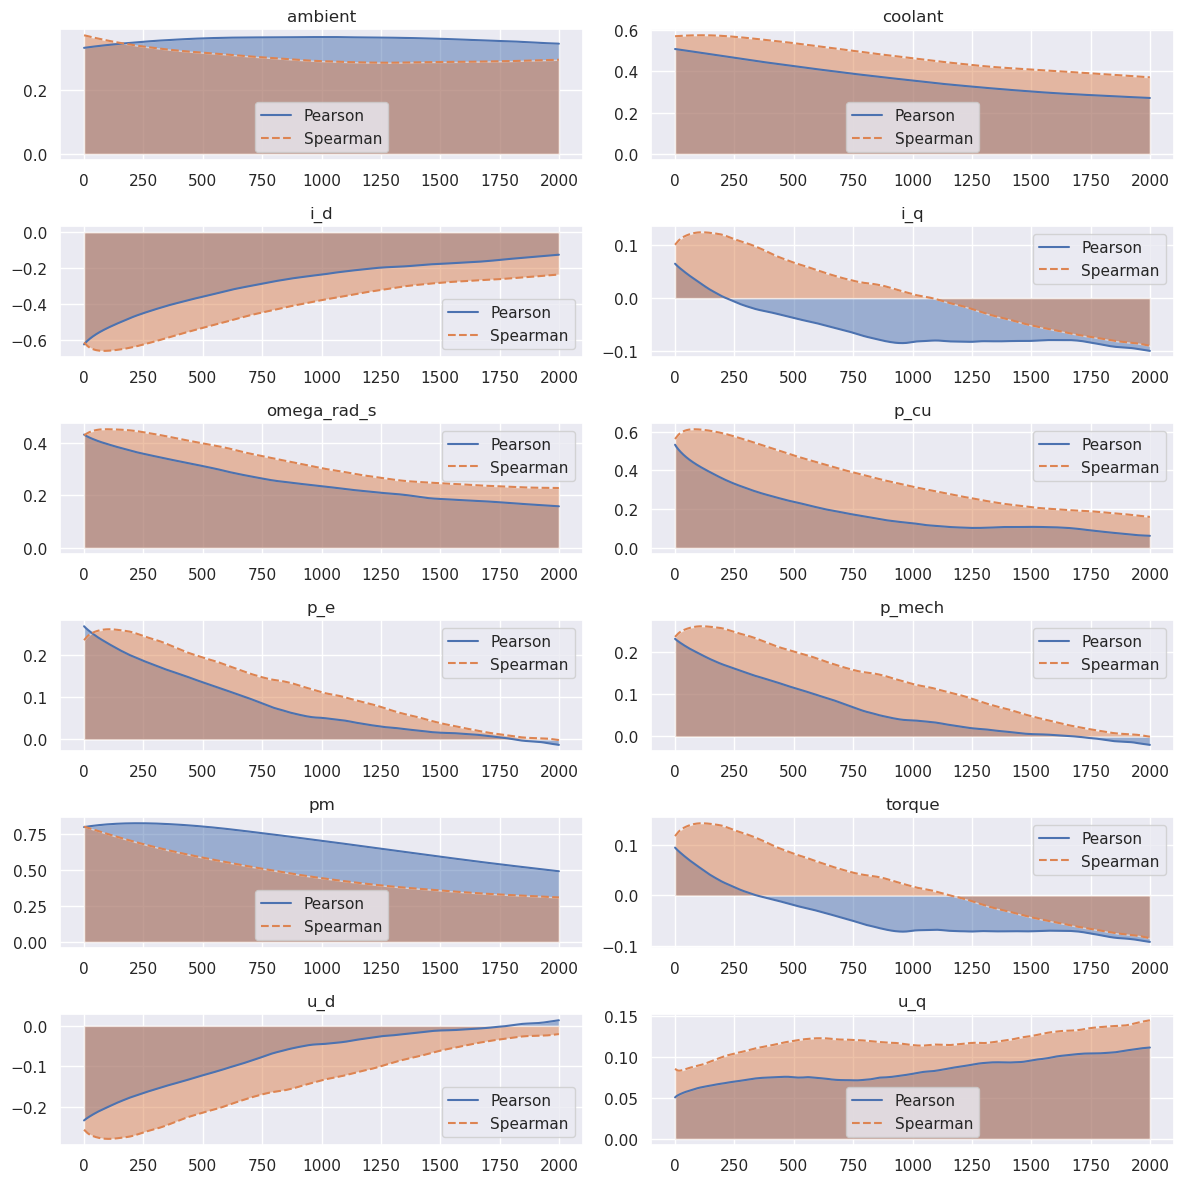

In [18]:
def spearman_ccf(x_raw: np.ndarray, y_raw: np.ndarray, max_lag: int) -> np.ndarray:
    """
    Spearman (rank-based) cross-correlation for non-negative lags.
    At lag k, correlates x[t] with y[t+k] so that positive lags mean 'x leads y'.
    """
    # align & drop NaNs jointly
    m = np.isfinite(x_raw) & np.isfinite(y_raw)
    x = x_raw[m]
    y = y_raw[m]
    if len(x) < 3:
        return np.full(max_lag, np.nan)

    # rank-transform once (global ranks) → Spearman
    xr = pd.Series(x).rank(method="average").to_numpy()
    yr = pd.Series(y).rank(method="average").to_numpy()

    vals = np.empty(max_lag, dtype=float)
    for k in range(max_lag):
        # x leads y by k → compare xr[0:len-k] with yr[k:len]
        if k == 0:
            a, b = xr, yr
        else:
            a, b = xr[:-k], yr[k:]
        if len(a) < 3:
            vals[k] = np.nan
        else:
            vals[k] = np.corrcoef(a, b)[0, 1]
    return vals

drivers = df.columns.difference(["time", "profile_id", "stator_winding", "stator_yoke", "stator_tooth", TARGET, "motor_speed", "p_mech_plus_p_cu", "p_res", "cluster"])
ncols, nrows = 2, int(np.ceil(len(drivers) / 2))
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 2*nrows))
axs = axs.flatten()
lags_dict = {}
for col, ax in zip(drivers, axs):
    x = df[col].dropna().astype(float).values
    x_std = (x - x.mean()) / (x.std() + 1e-9)
    
    ccf_vals = ccf(x_std, y_std)[:N_LAGS]
    spearman_vals = spearman_ccf(x_std, y_std, max_lag=N_LAGS)
    lags_dict[col] = {
        "pearson": np.argmax(abs(ccf_vals)) * DT,
        "spearman": np.argmax(abs(spearman_vals) * DT)
    }

    x_axis_vals = np.arange(len(ccf_vals))*DT
    ax.plot(x_axis_vals, ccf_vals, label="Pearson")
    ax.plot(x_axis_vals, spearman_vals, linestyle="--", label="Spearman")
    ax.fill_between(x_axis_vals, ccf_vals, alpha=0.5)
    ax.fill_between(x_axis_vals, spearman_vals, alpha=0.5)
    ax.set_title(f"{col}")
    ax.legend()
plt.tight_layout()
plt.show()

| Variable              | Pearson | Spearman | Relation to Stator Winding Temp |
|-----------------------|---------|----------|---------------------------------|
| **ambient**           | ~0.25   | ~0.30    | Acts as a slow boundary condition sets long-term equilibrium temperature |
| **coolant**           | ~0.40   | ~0.50    | Strong thermal driver, stator temp follows coolant dynamics, reflecting heat rejection efficiency. |
| **i_d**               | −0.60   | −0.40    | Negative link from field-weakening operation at high speeds. heating. |
| **i_q**               | −0.10   | +0.10    | Weak association, torque-producing current drives copper losses, but its effect is mostly captured through p_cu. |
| **omega_rad_s**       | ~0.40   | ~0.35    | Positive correlation, higher speeds increase iron losses and contribute to heating. |
| **p_cu**              | ~0.40   | ~0.55    | Direct proxy for Joule heating, strong and interpretable driver of stator temperature. |
| **p_e**               | ~0.20   | ~0.30    | Electrical input power, moderate link as it combines both useful work and losses. |
| **p_mech**            | ~0.20   | ~0.25    | Mechanical output, weak relation, mostly reflects operating load rather than direct heating. |
| **p_mech + p_cu**     | ~0.40   | ~0.45    | Combines copper losses and load, closer to power balance, capturing both heating and operating regime. |
| **pm (magnet temp)**  | ~0.75   | ~0.65    | Very strong thermal coupling; magnets and windings, tooths and yoke heat together due to shared thermal paths. |
| **torque**            | <0.10   | ~0.15    | Weak direct relation, heating influence is mediated through currents and copper losses. |
| **u_d**               | −0.20   | −0.10    | Weak negative link, reflects control actions (field weakening) rather than thermal effect. |
| **u_q**               | ~0.05   | ~0.10    | Very weak, voltages mainly reflect control effort, not directly tied to winding heating. |


In [19]:
lags_dict["mean"] = {
    "pearson": int(np.nanmean([v["pearson"] if (0 < v["pearson"] < N_LAGS-1) else np.nan for v in lags_dict.values()])),
    "spearman": int(np.nanmean([v["spearman"] if (0 < v["spearman"] < N_LAGS-1) else np.nan for v in lags_dict.values()]))
}
display(pd.DataFrame(lags_dict))

,ambient,coolant,i_d,i_q,omega_rad_s,p_cu,p_e,p_mech,pm,torque,u_d,u_q,mean
pearson,1033.0,0.0,0.0,1999.5,0.0,0.0,0.0,0.0,226.5,0.0,0.0,1999.5,1314
spearman,0.0,220.0,165.0,230.0,186.0,162.0,216.0,228.0,0.0,228.0,211.0,3999.0,205


It can also be seen that most features’ Spearman coefficients reach their maximum around the same lag (~120 s). This alignment provides a good approximation of the thermal delay of the system and serves as a strong candidate for defining both the forecasting horizon and the input window size.

> In other words, it’s the time it takes for changes in electrical/mechanical inputs (heating sources) to manifest in the stator temperature.

### Persistence Baselines

As seen in the ACF, the `stator_temperature` exhibits a slowly decaying autocorrelation and thus long thermal memory. This implies that, over short horizons, temperature can often be estimated using only its current value—without additional inputs.

A natural baseline is the persistence forecast, which assumes the future value equals the current value:

$$ T_{t+h} = T_{t} $$

In [20]:
horizons = np.array([15, 30, 60, 120, 300, 600, 1200]) // DT  # 15s, 30s, 60s, 2min, 5min, 10min at 2Hz
for h in horizons.astype(int):
    y_true = y.shift(-h)
    y_pred = y
    mask = y_true.notna()
    print(f"Persistence horizon {h*DT} s:", {
        "MAE": mae(y_true[mask], y_pred[mask]),
        "RMSE": rmse(y_true[mask], y_pred[mask])
    })

Persistence horizon 15.0 s: {'MAE': 0.8882191603813854, 'RMSE': 2.14902490525646}
Persistence horizon 30.0 s: {'MAE': 1.653066511140104, 'RMSE': 3.490048087392132}
Persistence horizon 60.0 s: {'MAE': 2.953841991571894, 'RMSE': 5.6915214276002875}
Persistence horizon 120.0 s: {'MAE': 5.012512696217534, 'RMSE': 9.108066162029766}
Persistence horizon 300.0 s: {'MAE': 9.485134930303266, 'RMSE': 16.135499343684284}
Persistence horizon 600.0 s: {'MAE': 14.567103266026349, 'RMSE': 22.90406986578639}
Persistence horizon 1200.0 s: {'MAE': 20.73107732201443, 'RMSE': 29.653964817436247}


This baseline sets the minimum performance threshold our models must exceed to be considered effective. If a model cannot outperform such a naïve strategy, simply shifting the current temperature value into the future, then it cannot be regarded as useful or reliable. Our models must capture thermal delays and exogenous drivers (currents, torque, coolant, etc.) that persistence ignores.

The high correlation or dependance of future values in current ones is a valuable insight for modeling: it suggests that approaches exploiting recursive structures may be well-suited, since they can leverage the information embedded in the actual temperature trajectory. 

## EDA Summary and Conclusions

- The dataset is overall **healthy**:  
  - No missing values.  
  - No constant variables across profiles.  
  - Only a few outliers or physical anomalies that require correction.  

- The strong correlation between **electrical power** and **mechanical power** reflects consistent measurements and a faithful physical representation of the motor system.  

- For the forecasting target, the **maximum temperature across stator winding, stator tooth, and stator yoke** will be used:  
  - High motor temperatures increase resistance and losses.  
  - This opens the possibility of replacing three sensors with one virtual sensor.  
  - These three temperature signals are highly correlated, so combining them avoids redundancy.  

- **Three clusters of driving profiles** were identified and can be leveraged for stratified splits during training.  
  This enables more informed training and evaluation across distinct operating regimes.  

- Correlation analysis shows the system has **long thermal memory and inertia**:  
  - The ACF displays a long tail, while the PACF highlights only the first few significant lags.  
  - A **thermal delay of ~200 s** was observed, representing the time required for electrical/mechanical inputs to manifest in winding temperature. This serves as a promising candidate for the forecasting horizon.  

- Final models must **outperform the persistence baseline** to be considered useful, since the high autocorrelation of stator temperature makes persistence already a strong predictor.  

- At this stage, only a few **physics-inspired features** were engineered.  
  The intention is to first test models with the base features, and introduce additional engineered proxies only if required.
